In [1]:
%matplotlib inline
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

In [3]:
from scipy.spatial import distance

class Data(object):
    # N points, k cluster, p dimensions
    def __init__(self, N, k, p):
        self.N = N
        self.k = k
        self.p = p
        self.true_center = []
        self.true_cluster_list = []
        self.data_set = []
        self.PIs = []
        self.means = []
        self.sigma = 0.0

    def init_board_gauss(self):
        n = float(self.N)/self.k
        X = []
        for i in range(self.k):
            c = ()
            # construct a random center point
            for j in range(self.p):
                c = c + (random.uniform(-1,1),)
            self.true_center.append(c)
            #s = random.uniform(0.05,0.5)
            s = 0.05
            x = []
            while len(x) < n:
                # need to change dimension
                lst = []
                for i in c:
                    lst.append(np.random.normal(i,s))
                point = np.array(lst)
                good = True
                for i in point:
                    if abs(i) >= 1:
                        good = False
                if good:
                    x.append(point)
            X.extend(x)
        X = np.array(X)[:self.N]
        return X

    def set_data(self, data):
        self.data_set = data
    # Taking in true center list, and the result center list
    def error_calculate(self,res):
        error = 0.0
        for i in range(self.k):
            min_dis = distance.euclidean(self.true_center[i],res[0])
            for j in range(self.k):
                # calculate the distance btw true center and kmean center
                dst = distance.euclidean(self.true_center[i],res[j])
                # find the minimum dst btw the true center and kmean center
                if dst < min_dis:
                    min_dis = dst
            error += min_dis * min_dis
        # print "the error rate is: ", error
        return math.sqrt(error / (self.sigma * self.sigma * self.p))

    # calculate the true function enables more kmean center than true center
    # this is for the true center 
    def true_cost_function(self):
        cost = 0.0
        # loop through the data set
        for data in self.data_set:
            # min_dist is the distance to the first true center
            min_dis = distance.euclidean(data,self.true_center[0])
            # loop through the true center
            for i in range(self.k):
                 # calculate the distance btw true center and kmean center
                dst = distance.euclidean(data,self.true_center[i])
                # find the minimum dst btw the true center and kmean center
                if dst < min_dis:
                    min_dis = dst
            cost += min_dis * min_dis
        return cost
    
    # this is for the cost function compared to the true center cost function
    def cost_function(self,res):
        cost = 0.0
        # loop through the whole dataset
        for data in self.data_set:
            min_dis = distance.euclidean(data,res[0])
            for i in range(len(res)):
                 # calculate the distance btw true center and kmean center
                dst = distance.euclidean(data,res[i])
                # find the minimum dst btw the true center and kmean center
                if dst < min_dis:
                    min_dis = dst
            cost += min_dis * min_dis
        # the ratio of result center cost/ true center cost
        return cost/self.true_cost_function()
            

    def set_true_center(self, means):
        self.true_center = means

    # mean is a p dimensional vector, covarience is a p*p matrix
    # number_of_sample is n samples
    # return value: n*p matrix, generate n samples from N(mean,covarience)
    def generate_mult_normal_data(self, mean, covariance, num_of_samples):
        return np.random.multivariate_normal(mean,covariance, num_of_samples)

    # prob is list of probability that sums to 1
    # means is a p dimensional vector,covarience is a p*p matrix
    # number_of_samples is n samples
    # return value: generate n samples from the mixture of Gaussian
    def generate_mult_normal_based_prob(self, prob, means, covariance, num_of_samples):
        data_list = []
        # keep track which points belong to which cluster
        true_cluster_list = []
        for i in range(num_of_samples):
            # flip a coin to see which cluster the data point comes from
            random_num = random.random()
            sum = 0.0
            index = -1
            for p in prob:
                if random_num < sum:
                    break
                sum += p
                index = index + 1
            true_cluster_list.append(index)
            # call the generate_mult_normal_data rountine
            data_list.append(self.generate_mult_normal_data(means[index], covariance,1)[0])
        self.true_cluster_list = true_cluster_list
        return np.array(data_list)[:num_of_samples]
        #return (np.array(data_list)[:num_of_samples], true_cluster_list)
    def generate_data(self, dimension, p_sigma, number_of_cluster, number_of_points):
        # dimension
        self.p = dimension

        # sqrt of variance
        self.sigma = p_sigma

        # k is number of clusters
        self.k = number_of_cluster

        # n is number of points to be generated
        self.N = number_of_points

        # init a covariance matrix as identity matrix
        self.identity_matrix = np.identity(self.p)

        # covariance matrix
        covariance = self.sigma * self.sigma * self.identity_matrix
        # choose means from


        # means are from a normal distribution with center is all 0s and varience N(0,sigma squre identity matrix)
        mean = []
        for i in range(self.p):
            mean.append(0)
        # choose means, k is the number of centers/cluster
        self.means = self.generate_mult_normal_data(mean, covariance, self.k)

        self.set_true_center(self.means)

        # choose pis, ASA probabolity
        self.PIs = []
        for i in range(self.k):
            # every cluster has the same probability
            self.PIs.append(1.0/self.k)

        # generate n points from the mixture model
        self.data_set = self.generate_mult_normal_based_prob(self.PIs, self.means, covariance, self.N)

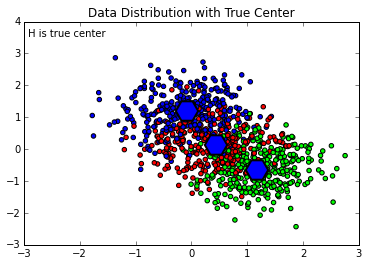

In [13]:
import random
import pylab
#color list
color_list = ([1,0,0],[0,1,0],[0,0,1],[1,1,0],[0,1,1],[1,1,0.7],[0.7,1,0],[1,0,0.7],[0.5,0.5,0], [0.5, 0, 0.5])

# create a data object
# number of points, k clusters, p dimensions
d = Data(1000, 3, 3)
# dimesion, sigma, cluster, # of points
d.generate_data(3, 0.6, 3, 1000)

# true center with true cluster
colors = ([color_list[i] for i in d.true_cluster_list])
pylab.scatter(d.data_set[:,0],d.data_set[:,1], c=colors)
pylab.title("Data Distribution with True Center")
pylab.figtext(0.135,0.85,'H is true center')
# hetagon means true center
pylab.scatter(d.true_center[:,0],d.true_center[:,1], marker='H', s = 500, linewidths=2)
pylab.show()
pylab.clf()

number of estimated clusters : 3


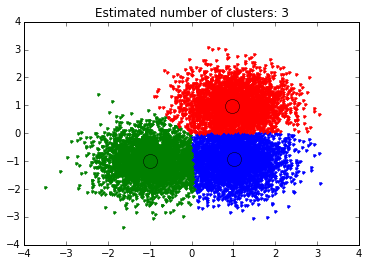

In [28]:
###############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]

X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

###############################################################################
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
# estimate on Data d

bandwidth = estimate_bandwidth(X, quantile=0.1, n_samples=10000)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

###############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
# implement simple mean shift

import numpy as np

mu, sigma = 9.8732, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
#print s

# random pick a point and look at the nearest 20 neighbors and take the average 
from random import randrange

threshold = 0.00001
prev = 0.0
current = 1000.0

# while less than threshold
while abs(current-prev) >= threshold:
    # random choose a point
    random_index = randrange(0,len(s))
    # left 10 points
    mean = 0.0
    count = 0 # count how many points added to the mean
    # left 10 points include itself
    for i in range (0,11):
        # if no more left break out of the for loop
        if (random_index - i) < 0:
            break
        mean = mean + s[random_index-i]
        count = count + 1
    # right 9 points not including itself
    for j in range(1,10):
        if (random_index + j)>=len(s):
            break
        mean = mean + s[random_index+j]
        count = count + 1
    mean = mean/count
    prev = current
    current = mean
    print "current is ", current
    print "prev is ", prev
    
#print "converged mode is ", current

10.0042981494
9.97355484364
9.97998887678
10.0149211996
10.0182284293
9.99328380754
9.99663060467
9.98346279752
9.96754951838
9.99579200976
10.0257711491
9.99433203912
10.0484835536
9.99246470933
9.98642860744
10.0333337267
9.96864289377
9.97073694589
9.98981359492
9.96233925394
9.97972468149
9.94712944998
9.95483772461
10.0352934512
10.0164570924
10.0185214574
10.0043411231
9.95215627647
10.0226700739
10.0444244915
10.0187676333
10.0035362694
10.0226700739
10.0162208325
10.0134949043
10.0333483977
9.99560964978
10.0092189289
9.975728927
9.95041894856
9.99251706989
9.99437888438
10.0112792796
10.0182284293
9.99151554371
9.98049218763
9.98592290102
9.9788168507
9.99958781457
9.99951351051
9.98462521444
9.98336823673
10.0103775995
10.028459127
9.99523052451
9.97407350634
9.98014461377
9.97694112706
10.0245621228
9.98370199403
10.0148064974
10.0345550717
9.99431761103
10.0000522927
10.0202948189
9.98429300778
10.0367753143
10.0081722554
10.0420575546
9.97403052776
10.0162072165
10.0259144

In [30]:
"""Mean shift clustering algorithm.
Mean shift clustering aims to discover *blobs* in a smooth density of
samples. It is a centroid based algorithm, which works by updating candidates
for centroids to be the mean of the points within a given region. These
candidates are then filtered in a post-processing stage to eliminate
near-duplicates to form the final set of centroids.
Seeding is performed using a binning technique for scalability.
"""

# Authors: Conrad Lee <conradlee@gmail.com>
#          Alexandre Gramfort <alexandre.gramfort@inria.fr>
#          Gael Varoquaux <gael.varoquaux@normalesup.org>
import warnings

'''
from collections import defaultdict
from ..externals import six
from ..utils.validation import check_is_fitted
from ..utils import extmath, check_random_state, gen_batches, check_array
from ..base import BaseEstimator, ClusterMixin
from ..neighbors import NearestNeighbors
from ..metrics.pairwise import pairwise_distances_argmin
'''

def estimate_bandwidth(X, quantile=0.3, n_samples=None, random_state=0):
    """Estimate the bandwidth to use with the mean-shift algorithm.
    That this function takes time at least quadratic in n_samples. For large
    datasets, it's wise to set that parameter to a small value.
    Parameters
    ----------
    X : array-like, shape=[n_samples, n_features]
        Input points.
    quantile : float, default 0.3
        should be between [0, 1]
        0.5 means that the median of all pairwise distances is used.
    n_samples : int, optional
        The number of samples to use. If not given, all samples are used.
    random_state : int or RandomState
        Pseudo-random number generator state used for random sampling.
    Returns
    -------
    bandwidth : float
        The bandwidth parameter.
    """
    random_state = check_random_state(random_state)
    if n_samples is not None:
        idx = random_state.permutation(X.shape[0])[:n_samples]
        X = X[idx]
    nbrs = NearestNeighbors(n_neighbors=int(X.shape[0] * quantile))
    nbrs.fit(X)

    bandwidth = 0.
    for batch in gen_batches(len(X), 500):
        d, _ = nbrs.kneighbors(X[batch, :], return_distance=True)
        bandwidth += np.max(d, axis=1).sum()

    return bandwidth / X.shape[0]


def mean_shift(X, bandwidth=None, seeds=None, bin_seeding=False,
               min_bin_freq=1, cluster_all=True, max_iter=300,
               max_iterations=None):
    """Perform mean shift clustering of data using a flat kernel.
    Parameters
    ----------
    X : array-like, shape=[n_samples, n_features]
        Input data.
    bandwidth : float, optional
        Kernel bandwidth.
        If bandwidth is not given, it is determined using a heuristic based on
        the median of all pairwise distances. This will take quadratic time in
        the number of samples. The sklearn.cluster.estimate_bandwidth function
        can be used to do this more efficiently.
    seeds : array-like, shape=[n_seeds, n_features] or None
        Point used as initial kernel locations. If None and bin_seeding=False,
        each data point is used as a seed. If None and bin_seeding=True,
        see bin_seeding.
    bin_seeding : boolean, default=False
        If true, initial kernel locations are not locations of all
        points, but rather the location of the discretized version of
        points, where points are binned onto a grid whose coarseness
        corresponds to the bandwidth. Setting this option to True will speed
        up the algorithm because fewer seeds will be initialized.
        Ignored if seeds argument is not None.
    min_bin_freq : int, default=1
       To speed up the algorithm, accept only those bins with at least
       min_bin_freq points as seeds.
    cluster_all : boolean, default True
        If true, then all points are clustered, even those orphans that are
        not within any kernel. Orphans are assigned to the nearest kernel.
        If false, then orphans are given cluster label -1.
    max_iter : int, default 300
        Maximum number of iterations, per seed point before the clustering
        operation terminates (for that seed point), if has not converged yet.
    Returns
    -------
    cluster_centers : array, shape=[n_clusters, n_features]
        Coordinates of cluster centers.
    labels : array, shape=[n_samples]
        Cluster labels for each point.
    Notes
    -----
    See examples/cluster/plot_meanshift.py for an example.
    """
    # FIXME To be removed in 0.18
    if max_iterations is not None:
        warnings.warn("The `max_iterations` parameter has been renamed to "
                      "`max_iter` from version 0.16. The `max_iterations` "
                      "parameter will be removed in 0.18", DeprecationWarning)
        max_iter = max_iterations

    if bandwidth is None:
        bandwidth = estimate_bandwidth(X)
    elif bandwidth <= 0:
        raise ValueError("bandwidth needs to be greater than zero or None, got %f" %
                         bandwidth)
    if seeds is None:
        if bin_seeding:
            seeds = get_bin_seeds(X, bandwidth, min_bin_freq)
        else:
            seeds = X
    n_samples, n_features = X.shape
    stop_thresh = 1e-3 * bandwidth  # when mean has converged
    center_intensity_dict = {}
    nbrs = NearestNeighbors(radius=bandwidth).fit(X)

    # For each seed, climb gradient until convergence or max_iter
    for my_mean in seeds:
        completed_iterations = 0
        while True:
            # Find mean of points within bandwidth
            i_nbrs = nbrs.radius_neighbors([my_mean], bandwidth,
                                           return_distance=False)[0]
            points_within = X[i_nbrs]
            if len(points_within) == 0:
                break  # Depending on seeding strategy this condition may occur
            my_old_mean = my_mean  # save the old mean
            my_mean = np.mean(points_within, axis=0)
            # If converged or at max_iter, adds the cluster
            if (extmath.norm(my_mean - my_old_mean) < stop_thresh or
                    completed_iterations == max_iter):
                center_intensity_dict[tuple(my_mean)] = len(points_within)
                break
            completed_iterations += 1

    if not center_intensity_dict:
        # nothing near seeds
        raise ValueError("No point was within bandwidth=%f of any seed."
                         " Try a different seeding strategy or increase the bandwidth."
                         % bandwidth)

    # POST PROCESSING: remove near duplicate points
    # If the distance between two kernels is less than the bandwidth,
    # then we have to remove one because it is a duplicate. Remove the
    # one with fewer points.
    sorted_by_intensity = sorted(center_intensity_dict.items(),
                                 key=lambda tup: tup[1], reverse=True)
    sorted_centers = np.array([tup[0] for tup in sorted_by_intensity])
    unique = np.ones(len(sorted_centers), dtype=np.bool)
    nbrs = NearestNeighbors(radius=bandwidth).fit(sorted_centers)
    for i, center in enumerate(sorted_centers):
        if unique[i]:
            neighbor_idxs = nbrs.radius_neighbors([center],
                                                  return_distance=False)[0]
            unique[neighbor_idxs] = 0
            unique[i] = 1  # leave the current point as unique
    cluster_centers = sorted_centers[unique]

    # ASSIGN LABELS: a point belongs to the cluster that it is closest to
    nbrs = NearestNeighbors(n_neighbors=1).fit(cluster_centers)
    labels = np.zeros(n_samples, dtype=np.int)
    distances, idxs = nbrs.kneighbors(X)
    if cluster_all:
        labels = idxs.flatten()
    else:
        labels.fill(-1)
        bool_selector = distances.flatten() <= bandwidth
        labels[bool_selector] = idxs.flatten()[bool_selector]
    return cluster_centers, labels


def get_bin_seeds(X, bin_size, min_bin_freq=1):
    """Finds seeds for mean_shift.
    Finds seeds by first binning data onto a grid whose lines are
    spaced bin_size apart, and then choosing those bins with at least
    min_bin_freq points.
    Parameters
    ----------
    X : array-like, shape=[n_samples, n_features]
        Input points, the same points that will be used in mean_shift.
    bin_size : float
        Controls the coarseness of the binning. Smaller values lead
        to more seeding (which is computationally more expensive). If you're
        not sure how to set this, set it to the value of the bandwidth used
        in clustering.mean_shift.
    min_bin_freq : integer, optional
        Only bins with at least min_bin_freq will be selected as seeds.
        Raising this value decreases the number of seeds found, which
        makes mean_shift computationally cheaper.
    Returns
    -------
    bin_seeds : array-like, shape=[n_samples, n_features]
        Points used as initial kernel positions in clustering.mean_shift.
    """

    # Bin points
    bin_sizes = defaultdict(int)
    for point in X:
        binned_point = np.round(point / bin_size)
        bin_sizes[tuple(binned_point)] += 1

    # Select only those bins as seeds which have enough members
    bin_seeds = np.array([point for point, freq in six.iteritems(bin_sizes) if
                          freq >= min_bin_freq], dtype=np.float32)
    if len(bin_seeds) == len(X):
        warnings.warn("Binning data failed with provided bin_size=%f, using data"
                      " points as seeds." % bin_size)
        return X
    bin_seeds = bin_seeds * bin_size
    return bin_seeds


class MeanShift(BaseEstimator, ClusterMixin):
    """Mean shift clustering using a flat kernel.
    Mean shift clustering aims to discover "blobs" in a smooth density of
    samples. It is a centroid-based algorithm, which works by updating
    candidates for centroids to be the mean of the points within a given
    region. These candidates are then filtered in a post-processing stage to
    eliminate near-duplicates to form the final set of centroids.
    Seeding is performed using a binning technique for scalability.
    Parameters
    ----------
    bandwidth : float, optional
        Bandwidth used in the RBF kernel.
        If not given, the bandwidth is estimated using
        sklearn.cluster.estimate_bandwidth; see the documentation for that
        function for hints on scalability (see also the Notes, below).
    seeds : array, shape=[n_samples, n_features], optional
        Seeds used to initialize kernels. If not set,
        the seeds are calculated by clustering.get_bin_seeds
        with bandwidth as the grid size and default values for
        other parameters.
    bin_seeding : boolean, optional
        If true, initial kernel locations are not locations of all
        points, but rather the location of the discretized version of
        points, where points are binned onto a grid whose coarseness
        corresponds to the bandwidth. Setting this option to True will speed
        up the algorithm because fewer seeds will be initialized.
        default value: False
        Ignored if seeds argument is not None.
    min_bin_freq : int, optional
       To speed up the algorithm, accept only those bins with at least
       min_bin_freq points as seeds. If not defined, set to 1.
    cluster_all : boolean, default True
        If true, then all points are clustered, even those orphans that are
        not within any kernel. Orphans are assigned to the nearest kernel.
        If false, then orphans are given cluster label -1.
    Attributes
    ----------
    cluster_centers_ : array, [n_clusters, n_features]
        Coordinates of cluster centers.
    labels_ :
        Labels of each point.
    Notes
    -----
    Scalability:
    Because this implementation uses a flat kernel and
    a Ball Tree to look up members of each kernel, the complexity will is
    to O(T*n*log(n)) in lower dimensions, with n the number of samples
    and T the number of points. In higher dimensions the complexity will
    tend towards O(T*n^2).
    Scalability can be boosted by using fewer seeds, for example by using
    a higher value of min_bin_freq in the get_bin_seeds function.
    Note that the estimate_bandwidth function is much less scalable than the
    mean shift algorithm and will be the bottleneck if it is used.
    References
    ----------
    Dorin Comaniciu and Peter Meer, "Mean Shift: A robust approach toward
    feature space analysis". IEEE Transactions on Pattern Analysis and
    Machine Intelligence. 2002. pp. 603-619.
    """
    def __init__(self, bandwidth=None, seeds=None, bin_seeding=False,
                 min_bin_freq=1, cluster_all=True):
        self.bandwidth = bandwidth
        self.seeds = seeds
        self.bin_seeding = bin_seeding
        self.cluster_all = cluster_all
        self.min_bin_freq = min_bin_freq

    def fit(self, X, y=None):
        """Perform clustering.
        Parameters
        -----------
        X : array-like, shape=[n_samples, n_features]
            Samples to cluster.
        """
        X = check_array(X)
        self.cluster_centers_, self.labels_ = \
            mean_shift(X, bandwidth=self.bandwidth, seeds=self.seeds,
                       min_bin_freq=self.min_bin_freq,
                       bin_seeding=self.bin_seeding,
                       cluster_all=self.cluster_all)
        return self

    def predict(self, X):
        """Predict the closest cluster each sample in X belongs to.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape=[n_samples, n_features]
            New data to predict.
        Returns
        -------
        labels : array, shape [n_samples,]
            Index of the cluster each sample belongs to.
        """
        check_is_fitted(self, "cluster_centers_")

        return pairwise_distances_argmin(X, self.cluster_centers_)

NameError: name 'BaseEstimator' is not defined